# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Conteúdo</p></div>     
   
- Libraries
- Configurations
- Loading Data
- **Data Preparation** 
    - Encoding
    - Normalization
    - Standardzation
    - Feature Selection
- **Model** 
    - Train-Test Split
    - Cross Validation
    - Models
        - LightGBM Classifier
        - XGboost Classifier
        - Artifical Neural Network
- **Hypertuning**
    - Optuna
        - LightGBM Classifier
        - XGboost Classifier
        - Artifical Neural Network
     - Save Best Models
- **Feture Importance**
    - Enssemble Method
        - LightGBM Classifier Feature Importance
        - XGboost Classifier Feature Importance
    - Filter Method
        - Anova
        - Pearson Correlation
    - Wrapper Methods
        - Shapley

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Libraries</p></div>

In [24]:
# !pip install -U scikit-learn
# !pip install lightgbm
# !pip install optuna
# !pip install category-encoders
# !pip install -q -U torch watermark
# !pip install -q -U scikit-learn watermark
# !pip install graphviz
# !pip install shap

In [25]:
# Basic Tools
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Visualization Tools
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# File / OS tools
import json
from watermark import watermark
import os
import dotenv


# Machine Learning Models
import xgboost
from xgboost import XGBClassifier, plot_importance
import lightgbm
from lightgbm import LGBMClassifier, plot_importance 

# Deep Learning Models
import torch
from torch import nn, optim
import torch.nn.functional as F

# Preprocessing Tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder
from category_encoders.count import CountEncoder

# Model Selection Tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
import optuna

# Model Evaluation Tools
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, classification_report

# Feature Importance Tools
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, VarianceThreshold, SelectPercentile
import shap
from shap import plots

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Configurations</p></div>

In [26]:
#Global Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [27]:
%reload_ext watermark
%watermark -v -p numpy,pandas,scikit-learn,optuna,lightgbm,torch,shap,category_encoders
#watermark --iversion

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

numpy            : 1.23.4
pandas           : 1.5.1
scikit-learn     : 0.0.post1
optuna           : 3.1.1
lightgbm         : 3.3.5
torch            : 2.0.0
shap             : 0.41.0
category_encoders: 2.6.0



# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preparation</p></div> 

In [28]:
dotenv.load_dotenv(dotenv.find_dotenv())
ROOT_DIR = os.getenv('ROOT_DIR')
data = pd.read_csv(f'{ROOT_DIR}/data/data_processed/data_processed.csv')

In [29]:
data_prep = data.copy()
data_prep.tail(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,people,kids,days_stay,country_name,continentes
119231,City Hotel,0,34,2017,August,35,31,2,5,2,...,157.71,0,4,Check-Out,2017-09-07,2,0,7,Germany,Europe
119232,City Hotel,0,109,2017,August,35,31,2,5,2,...,104.40,0,0,Check-Out,2017-09-07,2,0,7,United Kingdom,Europe
119233,City Hotel,0,205,2017,August,35,29,2,7,2,...,151.20,0,2,Check-Out,2017-09-07,2,0,9,Germany,Europe


In [30]:
data_prep.isna().sum().sum()

0

### <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Encoding</p></div>

In [31]:
## CATEGORICAL FEATURES

hotel_dict = {'City Hotel': 0,  'Resort Hotel':1}
data_prep['hotel'] = data_prep['hotel'].map(hotel_dict) 

meal_dict = {'SC': 0,  'HB': 1, 'BB': 2, 'FB':3}
data_prep['meal'] = data_prep['meal'].map(meal_dict)

continentes_dict = {'Unknow':-1,'Native': 0,'Europe': 1, 'Asia': 2, 'North America':3, 'South America':4, 'Oceania':5, 'Africa':6 }
data_prep['continentes'] = data_prep['continentes'].map(continentes_dict) 

market_segment_dict = {'Undefined':-1,'Online TA': 0,'Offline TA/TO': 1, 'Groups': 2, 'Corporate':3, 'Direct':4, 'Aviation':5, 'Complementary':6}
data_prep['market_segment'] = data_prep['market_segment'].map(market_segment_dict)

distribution_dict = {'Undefined':-1,'TA/TO': 0,'Direct': 1, 'Corporate': 2, 'GDS':3}
data_prep['distribution_channel'] = data_prep['distribution_channel'].map(distribution_dict) 

customer_type_dict = {'Transient': 0,'Transient-Party': 1, 'Contract': 2, 'Contract':3, 'Group':4}
data_prep['customer_type'] = data_prep['customer_type'].map(customer_type_dict) 


## NUMERICAL FEATURES
data_prep['previous_cancellations'] = data_prep['previous_cancellations'].apply(lambda x: 2 if (x >= 2) else x)
data_prep['previous_bookings_not_canceled'] = data_prep['previous_bookings_not_canceled'].apply(lambda x: 2 if (x >= 2) else x)
data_prep['booking_changes'] = data_prep['booking_changes'].apply(lambda x: 2 if (x >= 2) else x)

n = 20
top_agents = data_prep['agent'].value_counts().nlargest(n).index
top_companies = data_prep['company'].value_counts().nlargest(n).index
data_prep['agent'] = np.where(data_prep['agent'].isin(top_agents), data_prep['agent'], -1)
data_prep['company'] = np.where(data_prep['company'].isin(top_companies), data_prep['company'], -1)



## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Selection</p></div>

There are some features that we will **not use under any circumstances** in our machine learning model:

**reservation_status:** Data leakage<br>
**reservation_status_date:** Data Leakage<br>
**deposit_type:** The dataset seems to contain several wrong values about the type of deposit and its relationship with cancellations<br>


The remaining features were selected based on various tests that are not described on the notebook, with a focus on performance and simplicity:

**adults, children, babies:** Replaced by "people"<br>
**stays_in_weekend_nights, stays_in_week_nights:** Replaced with days_stay<br>
**country:** Replaced by continentes 


In [32]:
selected_features = ['hotel',
                     #'is_canceled',
                     'lead_time',
                     'arrival_date_year',   
                     #'arrival_date_month',
                     'arrival_date_week_number',
                     #'arrival_date_day_of_month',
                     #'stays_in_weekend_nights',                    
                     #'stays_in_week_nights',
                     #'adults',
                     #'children',
                     #'babies',
                     'meal',
                     #'country',
                     'market_segment',
                     'distribution_channel',
                     'is_repeated_guest',
                     'previous_cancellations',
                     #'assigned_room_type',
                     'previous_bookings_not_canceled',
                     #'reserved_room_type',
                     'booking_changes',
                     #'deposit_type',
                     'agent',
                     'company',
                     #'days_in_waiting_list',
                     'customer_type',
                     'adr',
                     'required_car_parking_spaces',
                     'total_of_special_requests',
                     #'reservation_status_date',
                     'people',
                     'continentes',
                     #'kids',
                     'days_stay',
                     #'foreigner'
                     #'arrival_date'
                    ]

In [33]:
target = 'is_canceled'

In [34]:
data_prep[selected_features]

,hotel,lead_time,arrival_date_year,arrival_date_week_number,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,people,continentes,days_stay
0,1,342,2015,27,2,4,1,0,0,0,2,0,0,0,0.00,0,0,2,0,0
1,1,737,2015,27,2,4,1,0,0,0,2,0,0,0,0.00,0,0,2,0,0
2,1,7,2015,27,2,4,1,0,0,0,0,0,0,0,75.00,0,0,1,1,1
3,1,13,2015,27,2,3,2,0,0,0,0,-1,0,0,75.00,0,0,1,1,1
4,1,14,2015,27,2,0,0,0,0,0,0,240,0,0,98.00,0,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,0,23,2017,35,2,1,0,0,0,0,0,-1,0,0,96.14,0,0,2,1,7
119230,0,102,2017,35,2,0,0,0,0,0,0,9,0,0,225.43,0,2,3,1,7
119231,0,34,2017,35,2,0,0,0,0,0,0,9,0,0,157.71,0,4,2,1,7
119232,0,109,2017,35,2,0,0,0,0,0,0,-1,0,0,104.40,0,0,2,1,7


## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Normalization</p></div>

In [35]:
log_columns = data_prep[selected_features].skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]
print('Columns/Skew\n',log_columns)    

Columns/Skew
 adr                               10.600349
people                            10.312170
company                            7.963720
previous_bookings_not_canceled     6.184619
is_repeated_guest                  5.364531
previous_cancellations             4.468142
required_car_parking_spaces        4.162833
days_stay                          3.190190
customer_type                      2.731746
booking_changes                    2.543387
continentes                        2.389070
distribution_channel               2.284368
agent                              1.688023
total_of_special_requests          1.349284
lead_time                          1.345750
market_segment                     1.115390
dtype: float64


In [36]:
# for col in log_columns.index:
#     data_prep[col] = np.log1p(data_prep[col])

In [37]:
rbs = RobustScaler()
for col in data_prep[selected_features]:
    data_prep[col] = rbs.fit_transform(data_prep[[col]]).squeeze()  

In [38]:
data_prep[selected_features]

,hotel,lead_time,arrival_date_year,arrival_date_week_number,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,people,continentes,days_stay
0,1.0,1.909091,-1.0,-0.045455,0.0,1.5,1.0,0.0,0.0,0.0,2.0,-0.642857,0.0,0.0,-1.679646,0.0,0.0,0.0,-1.0,-1.5
1,1.0,4.671329,-1.0,-0.045455,0.0,1.5,1.0,0.0,0.0,0.0,2.0,-0.642857,0.0,0.0,-1.679646,0.0,0.0,0.0,-1.0,-1.5
2,1.0,-0.433566,-1.0,-0.045455,0.0,1.5,1.0,0.0,0.0,0.0,0.0,-0.642857,0.0,0.0,-0.352212,0.0,0.0,-1.0,0.0,-1.0
3,1.0,-0.391608,-1.0,-0.045455,0.0,1.0,2.0,0.0,0.0,0.0,0.0,-0.714286,0.0,0.0,-0.352212,0.0,0.0,-1.0,0.0,-1.0
4,1.0,-0.384615,-1.0,-0.045455,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,16.500000,0.0,0.0,0.054867,0.0,1.0,0.0,0.0,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,0.0,-0.321678,1.0,0.318182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.714286,0.0,0.0,0.021947,0.0,0.0,0.0,0.0,2.0
119230,0.0,0.230769,1.0,0.318182,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.310265,0.0,2.0,1.0,0.0,2.0
119231,0.0,-0.244755,1.0,0.318182,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.111681,0.0,4.0,0.0,0.0,2.0
119232,0.0,0.279720,1.0,0.318182,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,-0.714286,0.0,0.0,0.168142,0.0,0.0,0.0,0.0,2.0


# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Model</p></div> 

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Train-Test Split</p></div>

In [39]:
y = data_prep[target]
X = data_prep[selected_features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((95387, 20), (95387,), (23847, 20), (23847,))

## <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Cross Validation</p></div>

In [40]:
def CM(y, y_pred):
    labels = ["Não Cancelado", "Cancelado"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred))   

In [41]:
def ROC(model, y, y_prob, model_dict):
    score_metrics_auc = pd.DataFrame(columns=['Model','AUC']) 
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = model_dict)    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    print(f"AUC: {auc:.4f}\n\n")     
   
    return y_prob, auc

In [87]:
def CVS(model, X, y, model_dict=''):    
    
   
    number_folds = 5
    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:,1]
    
    ### Defining threshold ###
    y_pred = np.empty(shape=(len(y_prob)))
    threshold = 0.5
    for i in range(len(y_prob)):    
        if y_prob[i] >= threshold:
            y_pred[i] = 1  
        else:
            y_pred[i] = 0  
   
    CM(y,y_pred)
    ROC(model, y, y_prob, model_dict) 
  
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])
    json_scores = df[['value','std']].to_json()
    
    
    
    f1_train_mean = round(np.mean(scores['train_f1']),5)
    f1_train_std = round(np.std(scores['train_f1']),5)
    f1_val_mean = round(np.mean(scores['test_f1']),5)
    f1_val_std = round(np.std(scores['test_f1']),5)
    
    f1_results = {
    'Train Mean': f1_train_mean,
    'Train Std': f1_train_std,
    'Val Mean': f1_val_mean,
    'Val Std': f1_val_std        
    }
    
    json_data = json.dumps(f1_results)
    
    
    
    
    
    
    
    
    return y_prob, y_pred, json_data

In [88]:
results = data.copy()

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div>

In [89]:
lgbm = LGBMClassifier(random_state=RANDOM_SEED)

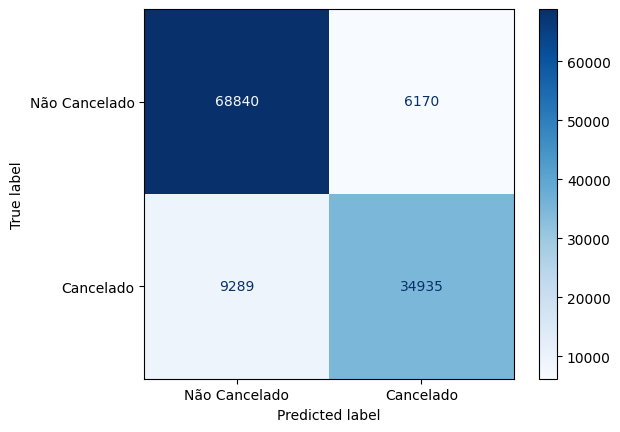

Score: 
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     75010
           1       0.85      0.79      0.82     44224

    accuracy                           0.87    119234
   macro avg       0.87      0.85      0.86    119234
weighted avg       0.87      0.87      0.87    119234



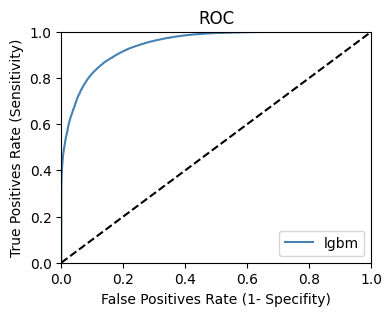

AUC: 0.9451




,value,std
fit_time,0.203409,0.015133
score_time,0.044924,0.007635
test_accuracy,0.870347,0.001350
train_accuracy,0.874189,0.000606
test_precision,0.849901,0.002188
train_precision,0.855796,0.001505
test_recall,0.789956,0.002810
train_recall,0.794710,0.001651
test_f1,0.818829,0.001978
train_f1,0.824120,0.000870


In [90]:
lgbm_y_prob, lgbm_y_pred, lgbm_scores  = CVS(lgbm,X,y,'lgbm')

In [91]:
lgbm_scores

'{"Train Mean": 0.8241, "Train Std": 0.0009, "Val Mean": 0.8188, "Val Std": 0.002}'

In [77]:
import numpy as np

# Dicionário com os dados
data = {
    'fit_time': np.array([0.27275848, 0.16386056, 0.1622231 , 0.19538474, 0.16587353]),
    'score_time': np.array([0.03836584, 0.04068398, 0.03817701, 0.04443789, 0.03783083]),
    'test_accuracy': np.array([0.87034008, 0.86782404, 0.87176584, 0.87113683, 0.87067013]),
    'train_accuracy': np.array([0.87437491, 0.87473136, 0.87336849, 0.87358864, 0.87487944]),
    'test_precision': np.array([0.85100671, 0.84700719, 0.85342616, 0.84947929, 0.84858388]),
    'train_precision': np.array([0.85817514, 0.85675132, 0.85423255, 0.85430403, 0.85551815]),
    'test_recall': np.array([0.78846806, 0.78552855, 0.78993782, 0.79310345, 0.79274084]),
    'train_recall': np.array([0.79222137, 0.7952175 , 0.79408689, 0.79470873, 0.79731487]),
    'test_f1': np.array([0.8185446 , 0.81511028, 0.82045561, 0.82032392, 0.81971238]),
    'train_f1': np.array([0.82388042, 0.82483838, 0.82306239, 0.82342949, 0.82539172]),
    'test_roc_auc': np.array([0.94534234, 0.944352  , 0.94634525, 0.94596659, 0.94365226]),
    'train_roc_auc': np.array([0.94941244, 0.94922996, 0.94893938, 0.94934414, 0.94951346])
}

# Calcular média e desvio padrão para cada chave do dicionário
results = {}
for key, value in data.items():
    mean = np.mean(value)
    std = np.std(value)
    results[key] = {
        'mean': mean,
        'std': std
    }

# Exibir resultados
for key, value in results.items():
    print(f'{key}: Mean={value["mean"]:.4f}, Std={value["std"]:.4f}')

fit_time: Mean=0.1920, Std=0.0422
score_time: Mean=0.0399, Std=0.0025
test_accuracy: Mean=0.8703, Std=0.0013
train_accuracy: Mean=0.8742, Std=0.0006
test_precision: Mean=0.8499, Std=0.0022
train_precision: Mean=0.8558, Std=0.0015
test_recall: Mean=0.7900, Std=0.0028
train_recall: Mean=0.7947, Std=0.0017
test_f1: Mean=0.8188, Std=0.0020
train_f1: Mean=0.8241, Std=0.0009
test_roc_auc: Mean=0.9451, Std=0.0010
train_roc_auc: Mean=0.9493, Std=0.0002


In [48]:
# # Converter arrays para listas
# scores = {key: value.tolist() for key, value in lgbm_scores.items()}

# # Converter dicionário para JSON
# json_data = json.dumps(scores)

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGboost</p></div>

In [22]:
xgb = XGBClassifier(random_state=RANDOM_SEED)

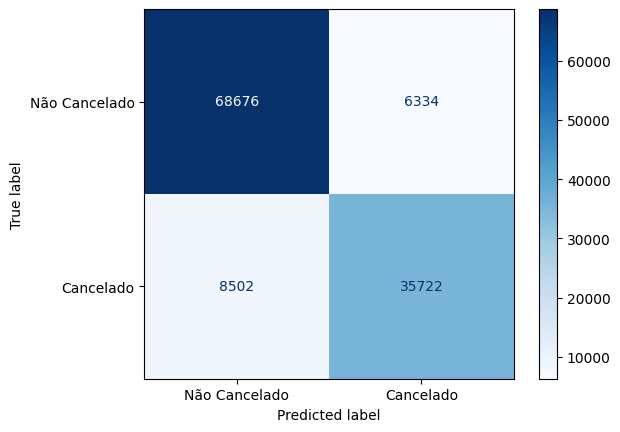

Score: 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     75010
           1       0.85      0.81      0.83     44224

    accuracy                           0.88    119234
   macro avg       0.87      0.86      0.87    119234
weighted avg       0.87      0.88      0.87    119234



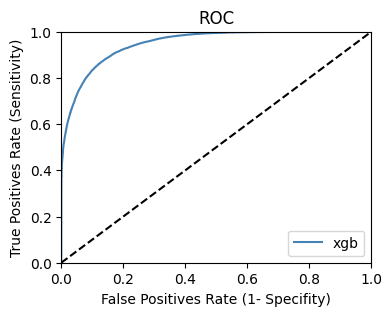

AUC: 0.9493




,0,1,2,3,4,mean_folds5,std
fit_time,1.273946,1.243605,1.311627,1.337808,1.466887,1.326775,0.077059
score_time,0.030308,0.030315,0.030138,0.034082,0.035440,0.032057,0.002251
test_accuracy,0.876337,0.873066,0.876546,0.876840,0.875073,0.875572,0.001391
train_accuracy,0.891348,0.890499,0.889849,0.890729,0.888571,0.890199,0.000945
test_precision,0.849289,0.844260,0.853396,0.851416,0.848651,0.849402,0.003067
train_precision,0.871021,0.870512,0.867060,0.868931,0.866671,0.868839,0.001757
test_recall,0.810401,0.806557,0.805540,0.809158,0.807101,0.807751,0.001774
train_recall,0.829956,0.827921,0.830323,0.830691,0.826767,0.829131,0.001522
test_f1,0.829390,0.824978,0.828777,0.829749,0.827354,0.828050,0.001740
train_f1,0.849993,0.848682,0.848294,0.849381,0.846248,0.848520,0.001277


In [23]:
xgb_y_prob, xgb_y_pred, xgb_scores  = CVS(xgb,X,y,'xgb')

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">ANN</p></div>

In [24]:
X_train_nn = torch.from_numpy(X_train.to_numpy()).float()
y_train_nn = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_val_nn = torch.from_numpy(X_val.to_numpy()).float()
y_val_nn = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device
#device(type='cuda')

device(type='cpu')

In [26]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(95387, 20) (95387,)
(23847, 20) (23847,)


In [27]:
#batch_size = 64
#num_classes = 1

input_size = X.shape[1]
num_classes = 1
learning_rate = 0.01
hidden_size_1 = 200
hidden_size_2 = 400
dropout_rate = 0.1

In [28]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, dropout_rate):
        super(Net, self).__init__()
        self.hiden_layer1 = nn.Linear(input_size, hidden_size_1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.hiden_layer2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.output = nn.Linear(hidden_size_2, 1)
        
    def forward(self, x):
        x = torch.relu(self.hiden_layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.hiden_layer2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output(x))
        return x

In [29]:
net = Net(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, dropout_rate=dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_nn, y_train_nn = X_train_nn.to(device), y_train_nn.to(device)
X_val_nn, y_val_nn = X_val_nn.to(device), y_val_nn.to(device)

net = net.to(device)
criterion = criterion.to(device)

In [31]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    acc =  (y_true == predicted).sum().float() / len(y_true)
    
def calculate_f1(y_true, y_pred):
    #Class Probability
    predicted = y_pred.ge(.5).squeeze().long()
    y_true = y_true.long()
    #F1 Score Calculator
    f1 = f1_score(y_true, predicted, average='micro')

    return f1

def calculate_precision(y_true, y_pred):
    #Class Probability
    predicted = y_pred.ge(.5).squeeze().long()
    y_true = y_true.long()
    #F1 Score Calculator
    precision = precision_score(y_true, predicted)

    return precision 

def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [32]:
# Sub-Paramters
early_stop_epochs = 5
patience = 0
best_val_loss = float('inf')
num_epoch = 500

predictions = []

for epoch in range(num_epoch):
    y_pred = net(X_train_nn)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train_nn)
    if epoch % 10 == 0:
        train_score = calculate_f1(y_train_nn, y_pred)
        y_val_pred = net(X_val_nn)
        y_val_pred = torch.squeeze(y_val_pred)
        val_loss = criterion(y_val_pred, y_val_nn)
        val_score = calculate_f1(y_val_nn, y_val_pred)        
        print(f'epoch {epoch} - train loss: {round_tensor(train_loss)}, train f1 : {round_tensor(train_score)} val loss: {round_tensor(val_loss)}, val f1: {round_tensor(val_score)}')
        # Verify boost on validation set
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_epochs:
                print('Early Stopping')
                break
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    predictions.append({'epoch': epoch, 'y_pred': y_pred.detach().numpy(), 'y_val_pred': y_val_pred.detach().numpy()})

epoch 0 - train loss: 0.685, train f1 : 0.629 val loss: 0.685, val f1: 0.629
epoch 10 - train loss: 0.669, train f1 : 0.759 val loss: 0.672, val f1: 0.756
epoch 20 - train loss: 0.475, train f1 : 0.79 val loss: 0.475, val f1: 0.789
epoch 30 - train loss: 0.44, train f1 : 0.798 val loss: 0.444, val f1: 0.796
epoch 40 - train loss: 0.408, train f1 : 0.811 val loss: 0.413, val f1: 0.805
epoch 50 - train loss: 0.389, train f1 : 0.821 val loss: 0.394, val f1: 0.814
epoch 60 - train loss: 0.374, train f1 : 0.826 val loss: 0.379, val f1: 0.819
epoch 70 - train loss: 0.359, train f1 : 0.831 val loss: 0.366, val f1: 0.827
epoch 80 - train loss: 0.346, train f1 : 0.838 val loss: 0.354, val f1: 0.833
epoch 90 - train loss: 0.334, train f1 : 0.844 val loss: 0.339, val f1: 0.839
epoch 100 - train loss: 0.326, train f1 : 0.847 val loss: 0.335, val f1: 0.843
epoch 110 - train loss: 0.321, train f1 : 0.85 val loss: 0.328, val f1: 0.846
epoch 120 - train loss: 0.314, train f1 : 0.854 val loss: 0.325, v

In [40]:
X.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'company', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'people',
       'continentes', 'days_stay'],
      dtype='object')

In [42]:
novo = torch.tensor([[ 0.,-0.48251748,  0.,         -0.5 ,        0.,          1.5,
   1.,          0.,          0.,          0.,          0.,         -0.64285714,
   0.,          0.,          0.6920354,   0.,          0.,          1.,
   0.,        -1.        ]], dtype = torch.float)


In [39]:
net.eval()

Net(
  (hiden_layer1): Linear(in_features=20, out_features=200, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (hiden_layer2): Linear(in_features=200, out_features=400, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=400, out_features=1, bias=True)
)

In [81]:
X_nn = torch.from_numpy(X.to_numpy()).float()

In [82]:
X_train_nn = torch.from_numpy(X_train.to_numpy()).float()

In [83]:
previsão = net(X_nn).detach().numpy()

In [84]:
previsão = previsão.round(5)

In [85]:
results['nn_prob'] = previsão

In [86]:
results['nn_pred'] = results['nn_prob'].apply(lambda x: 1 if x >= 0.5 else 0)

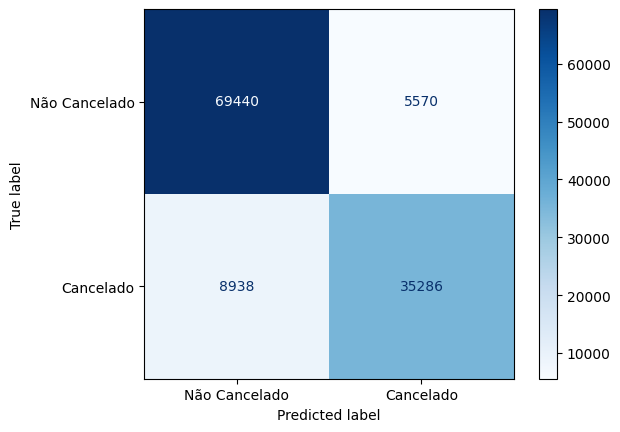

Score: 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     75010
           1       0.86      0.80      0.83     44224

    accuracy                           0.88    119234
   macro avg       0.87      0.86      0.87    119234
weighted avg       0.88      0.88      0.88    119234



In [94]:
CM(data.is_canceled, results.nn_pred)

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertuning</p></div> 

### <div style="color:white;display:fill;border-radius:5px;background-color:#2E6B8E;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Optuna</p></div>

In [54]:
weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
weight

1.696

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div>

In [55]:
def objective(trial):
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary']),#binary         
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        'metric': trial.suggest_categorical('metric', ['auc']), 
        #'eval_metric': trial.suggest_categorical('eval_metric', ['f1']),   
        #"metric": "binary_error",
        "num_leaves": trial.suggest_int("num_leaves", 100, 300, step=20),
        "max_depth": trial.suggest_int("max_depth", 6, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.9),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 0.9),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        #'is_unbalance': trial.suggest_categorical('is_unbalance', [False,True]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        #'boost_from_average': trial.suggest_categorical('boost_from_average', [False,True]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        #'early_stopping_rounds':10,
        #'verbosity':0,
        'seed': RANDOM_SEED
    }
    
    model = LGBMClassifier(**param_grid)
    
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    #scores = cross_val_score(model, X, y, cv=Kfold, scoring="precision")
    #return scores.mean()
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    return f1_score(y,y_pred)
    

In [35]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=100);

trial = study.best_trial

[I 2023-04-27 13:02:09,216] A new study created in memory with name: no-name-29d74bbe-0d19-46b3-a21d-299092a42c8f


In [36]:
# Print the result
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 0.8374325653804989

Optimized parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_leaves': 220, 'max_depth': 12, 'learning_rate': 0.08418990603825943, 'reg_alpha': 0.002068202122159695, 'reg_lambda': 0.3187176771918625, 'subsample_freq': 6, 'min_child_samples': 28, 'scale_pos_weight': 1.696}



In [56]:
lgbm_best_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_leaves': 220, 'max_depth': 12, 'learning_rate': 0.08418990603825943, 'reg_alpha': 0.002068202122159695, 'reg_lambda': 0.3187176771918625, 'subsample_freq': 6, 'min_child_samples': 28, 'scale_pos_weight': 1.696}

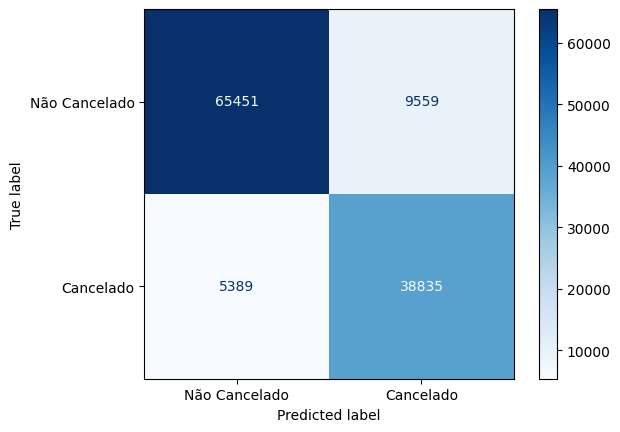

Score: 
               precision    recall  f1-score   support

           0       0.92      0.87      0.90     75010
           1       0.80      0.88      0.84     44224

    accuracy                           0.87    119234
   macro avg       0.86      0.88      0.87    119234
weighted avg       0.88      0.87      0.88    119234



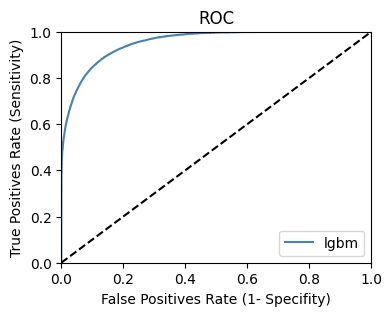

AUC: 0.9540




,0,1,2,3,4,mean_folds5,std
fit_time,0.433873,0.451340,0.495389,0.498172,0.473004,0.470356,0.024900
score_time,0.059393,0.069986,0.062671,0.062837,0.057500,0.062477,0.004262
test_accuracy,0.875372,0.872898,0.876504,0.875456,0.872935,0.874633,0.001457
train_accuracy,0.898078,0.898424,0.898718,0.898057,0.899002,0.898456,0.000366
test_precision,0.801954,0.798337,0.807100,0.802679,0.802372,0.802488,0.002787
train_precision,0.830197,0.831347,0.831708,0.831314,0.831761,0.831266,0.000564
test_recall,0.881741,0.879480,0.876540,0.880724,0.872230,0.878143,0.003433
train_recall,0.911671,0.910936,0.911332,0.909749,0.912210,0.911179,0.000829
test_f1,0.839957,0.836947,0.840388,0.839892,0.835844,0.838605,0.001846
train_f1,0.869029,0.869324,0.869701,0.868765,0.870130,0.869390,0.000484


In [57]:
model_lgbm_tuned = LGBMClassifier(**lgbm_best_params)
y_prob_lgbm_tuned, y_pred_lgbm_tuned, scores_lgbm_tuned  = CVS(model_lgbm_tuned,X,y,'lgbm')

In [61]:
results['lgbm_prob'] = y_prob_lgbm_tuned
results['lgbm_pred'] = y_pred_lgbm_tuned

In [39]:
lgbm_best_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 #'num_leaves': 280,
 'max_depth': 11,
 'learning_rate': 0.1,
 'reg_alpha': 1.2e-07,
 'reg_lambda': 4.6e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 'scale_pos_weight': 1.696}


param_range = np.arange(10, 300, 10)


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**lgbm_best_params,
        num_leaves = i
)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))

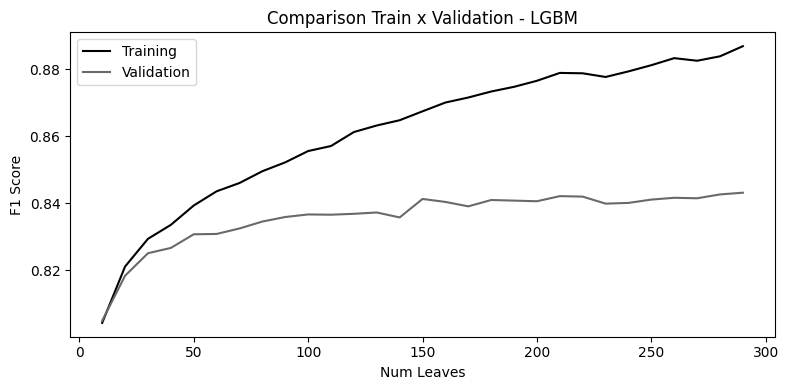

In [41]:
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("Num Leaves")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

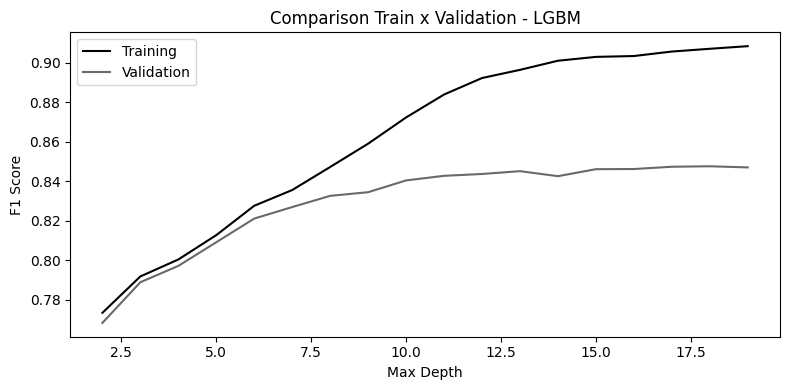

In [42]:
lgbm_best_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'num_leaves': 280,
 #'max_depth': 11,
 'learning_rate': 0.1,
 'reg_alpha': 1.2e-07,
 'reg_lambda': 4.6e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 'scale_pos_weight': 1.696}


param_range = np.arange(2, 20, 1)


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**lgbm_best_params,
        max_depth = i
)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

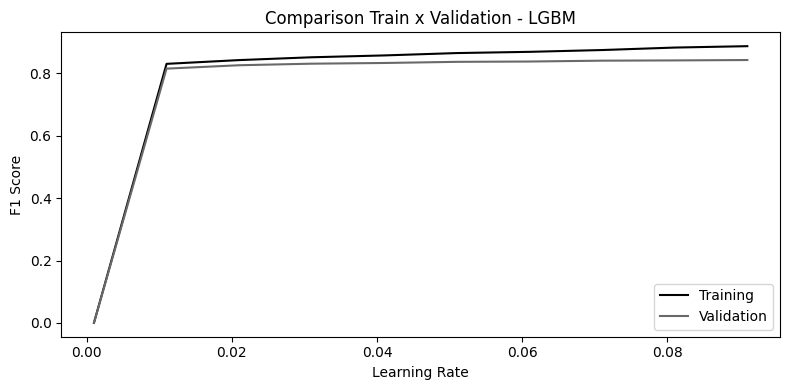

In [43]:
lgbm_best_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'num_leaves': 280,
 'max_depth': 12,
 #'learning_rate': 0.1,
 'reg_alpha': 1.2e-07,
 'reg_lambda': 4.6e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 'scale_pos_weight': 1.696}


param_range = np.arange(0.001, 0.1, 0.01)


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**lgbm_best_params,
        learning_rate = i
)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

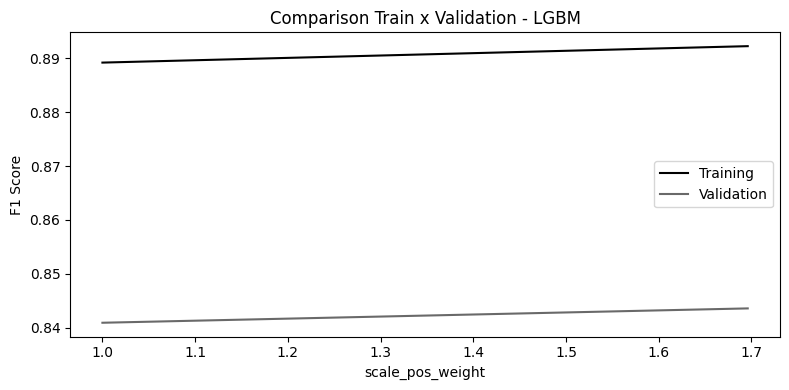

In [44]:
lgbm_best_params = {'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'num_leaves': 280,
 'max_depth': 12,
 'learning_rate': 0.1,
 'reg_alpha': 1.2e-07,
 'reg_lambda': 4.6e-06,
 'subsample_freq': 5,
 'min_child_samples': 2,
 #'scale_pos_weight': 1.696
                   }


param_range = [1,1.696]


train_scores = [ ]
val_scores = [ ]
for i in param_range:
    lgbm = LGBMClassifier(**lgbm_best_params,
        scale_pos_weight = i
)
    lgbm.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,lgbm.predict(X_train)))
    val_scores.append(f1_score(y_val,lgbm.predict(X_val)))
    
plt.figure(figsize=(8,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, val_scores, label="Validation", color="dimgrey")
 
plt.title("Comparison Train x Validation - LGBM")
plt.xlabel("scale_pos_weight")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best");

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGBoost</p></div>

In [62]:
def objective(trial): 
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),  
        'booster': trial.suggest_categorical('booster', ['gbtree','dart']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),    
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 150, step=50),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.4, 0.9),     
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,weight]),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED]),
        #'early_stopping_rounds':100,        
    }

    model = XGBClassifier(**param_grid)
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=RANDOM_SEED )
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    
    return f1_score(y,y_pred)

In [42]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study.optimize(objective, n_trials=100); 

trial = study.best_trial

In [43]:
# Print the result
xgb_best_params = study.best_params
xgb_best_score = study.best_value
print(f"Best score: {xgb_best_score}\n")
print(f"Optimized parameters: {xgb_best_params}\n")

Best score: 0.8430730973103855

Optimized parameters: {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.08954641832548456, 'n_estimators': 150, 'alpha': 0.044798317820219084, 'lambda': 1.3854331769012785e-05, 'min_child_weight': 1, 'colsample_bytree': 0.5179903201439937, 'scale_pos_weight': 1.696, 'seed': 42}



In [64]:
xgb_best_params = {'objective': 'binary:logistic', 'booster': 'dart', 'eval_metric': 'auc', 'max_depth': 10, 'learning_rate': 0.08954641832548456, 'n_estimators': 150, 'alpha': 0.044798317820219084, 'lambda': 1.3854331769012785e-05, 'min_child_weight': 1, 'colsample_bytree': 0.5179903201439937, 'scale_pos_weight': 1.696, 'seed': 42}

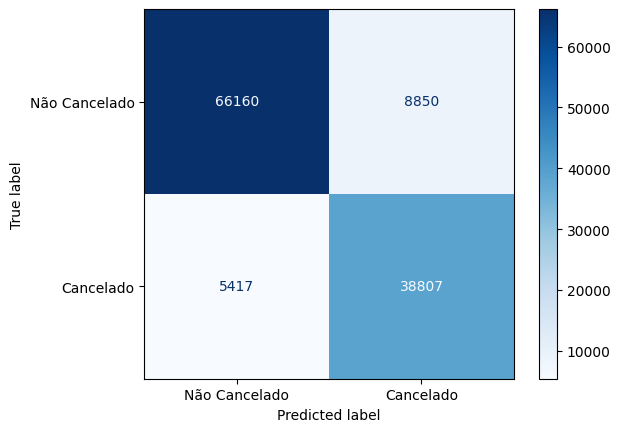

Score: 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90     75010
           1       0.81      0.88      0.84     44224

    accuracy                           0.88    119234
   macro avg       0.87      0.88      0.87    119234
weighted avg       0.88      0.88      0.88    119234



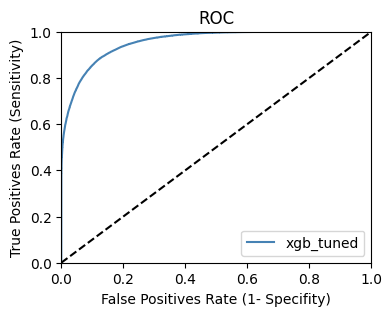

AUC: 0.9560




,0,1,2,3,4,mean_folds5,std
fit_time,10.556888,10.426845,10.451133,10.586459,10.481284,10.500522,0.061319
score_time,0.295216,0.247276,0.291823,0.287388,0.332981,0.290937,0.027224
test_accuracy,0.881495,0.877679,0.882501,0.881746,0.878302,0.880345,0.001960
train_accuracy,0.915932,0.914821,0.913867,0.913888,0.915073,0.914716,0.000778
test_precision,0.815825,0.808365,0.818153,0.814687,0.814525,0.814311,0.003244
train_precision,0.855122,0.854630,0.851697,0.852052,0.854080,0.853516,0.001385
test_recall,0.878915,0.878462,0.878462,0.881741,0.869968,0.877510,0.003964
train_recall,0.931089,0.928234,0.929648,0.929167,0.929904,0.929608,0.000934
test_f1,0.846196,0.841957,0.847236,0.846889,0.841334,0.844722,0.002542
train_f1,0.891490,0.889913,0.888967,0.888940,0.890380,0.889938,0.000953


In [65]:
model_xgb_tuned = XGBClassifier(**xgb_best_params)
y_prob_xgb_tuned, y_pred_xgb_tuned, scores_xgb_tuned  = CVS(model_xgb_tuned,X,y,'xgb_tuned')

In [66]:
results['xgb_prob'] = y_prob_xgb_tuned
results['xgb_pred'] = y_pred_xgb_tuned

In [48]:
#optuna.visualization.plot_optimization_history(study)

In [49]:
#optuna.visualization.plot_slice(study)

In [45]:
#optuna.visualization.plot_param_importances(study)

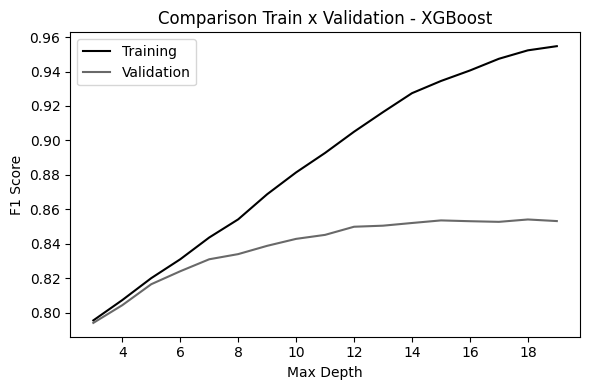

In [52]:
xgb_best_params = {'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gbtree',
 #'max_depth': 10,
 'learning_rate': 0.09971203875947736,
 'n_estimators': 150,
 'alpha': 2.957003467711026e-08,
 'lambda': 4.009830502312534e-07,
 'min_child_weight': 5,
 'colsample_bytree': 0.4584833524080041,
 'scale_pos_weight': 1.696,
 'seed': 42}


param_range = np.arange(3, 20, 1)


train_scores = [ ]
test_scores = [ ]
for i in param_range:
    xgb = XGBClassifier(**xgb_best_params,
        max_depth = i
)
    xgb.fit(X_train,y_train)
    train_scores.append(f1_score(y_train,xgb.predict(X_train)))
    test_scores.append(f1_score(y_val,xgb.predict(X_val)))
    

plt.subplots(1, figsize=(6,4))
plt.plot(param_range, train_scores, label="Training", color="black")
plt.plot(param_range, test_scores, label="Validation", color="dimgrey")

 
plt.title("Comparison Train x Validation - XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()    

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">ANN</p></div>

In [87]:
def objective_ann(trial):
    input_size = X.shape[1]
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    hidden_size_1 = trial.suggest_int('hidden_size_1', 100, 400, step=50)
    hidden_size_2 = trial.suggest_int('hidden_size_2', 100, 400, step=50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.1)

    net = Net(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    early_stop_epochs = 30
    patience = 0
    best_val_loss = float('inf')
    num_epoch = 300

    for epoch in range(num_epoch):
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        if epoch % 10 == 0:
            train_score = calculate_f1(y_train, y_pred)
            y_val_pred = net(X_val)
            y_val_pred = torch.squeeze(y_val_pred)
            val_loss = criterion(y_val_pred, y_val)
            val_acc = calculate_f1(y_val, y_val_pred)
            # Verificar se houve melhora no conjunto de validação
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
            else:
                patience += 1
                if patience >= early_stop_epochs:
                    break
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    return val_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective_ann, n_trials=100)

trial = study.best_trial

[I 2023-04-28 07:56:47,682] A new study created in memory with name: no-name-7700d302-a569-409b-91b1-925b22f2b8fc
[W 2023-04-28 07:56:47,690] Trial 0 failed with parameters: {'learning_rate': 0.010994301368448903, 'hidden_size_1': 350, 'hidden_size_2': 200, 'dropout_rate': 0.2} because of the following error: NameError("name 'Net' is not defined").
Traceback (most recent call last):
  File "/home/alysson/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_5028/1349641949.py", line 8, in objective_ann
    net = Net(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, dropout_rate=dropout_rate)
NameError: name 'Net' is not defined
[W 2023-04-28 07:56:47,692] Trial 0 failed with value None.


NameError: name 'Net' is not defined

In [ ]:
# Print the result
nn_best_params = study.best_params
nn_best_score = study.best_value
print(f"Best score: {nn_best_score}\n")
print(f"Optimized parameters: {nn_best_params}\n")

# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Save Model</p></div> 

In [53]:
params_dir = os.path.join(ROOT_DIR, "config", "params")
os.makedirs(params_dir, exist_ok=True) #O parâmetro exist_ok=True faz com que a função não retorne um erro caso a pasta já exista.
now = dt.now().strftime('%Y%m%d%H%M%S')

    
# for dirname, _, filenames in os.walk(f'{ROOT_DIR}\config\params'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))    

In [54]:
filename_xgb = f'xgb_best_params_{now}_v1.0.json'
params_path = os.path.join(params_dir, filename_xgb)


with open(params_path, 'w') as f:
    json.dump(xgb_best_params, f)

In [55]:
filename_lgbm = f'lgbm_best_params_{now}_v1.0.json'
params_path = os.path.join(params_dir, filename_lgbm)


with open(params_path, 'w') as f:
    json.dump(lgbm_best_params, f)

In [56]:
# NN_name = 'nn_model.pth'
# model_dir = os.path.join(ROOT_DIR, "models")
# os.makedirs(model_dir, exist_ok=True)
# params_path = os.path.join(params_dir, NN_name)

# torch.save(net, NN_name)

In [57]:
# import optuna
# import logging

# logger = logging.getLogger()

# logger.setLevel(logging.INFO)  # Setup the root logger.
# logger.addHandler(logging.FileHandler("foo.log", mode="w"))

# optuna.logging.enable_propagation()  # Propagate logs to the root logger.
# optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

# study = optuna.create_study()

# logger.info("Start optimization.")
# study.optimize(objective, n_trials=10)

# with open("foo.log") as f:
#     assert f.readline().startswith("A new study created")
#     assert f.readline() == "Start optimization.\n"

# Return Table

In [87]:
results

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,kids,days_stay,country_name,continentes,lgbm_prob,lgbm_pred,xgb_prob,xgb_pred,nn_prob,nn_pred
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,Portugal,Native,0.391546,0.0,0.114176,0.0,0.03295,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,Portugal,Native,0.657175,1.0,0.223782,0.0,0.00038,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,1,United Kingdom,Europe,0.025873,0.0,0.006839,0.0,0.03926,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,1,United Kingdom,Europe,0.015236,0.0,0.028004,0.0,0.02619,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,2,United Kingdom,Europe,0.011047,0.0,0.009087,0.0,0.00032,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119229,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,7,Belgium,Europe,0.004098,0.0,0.003196,0.0,0.00009,0
119230,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,7,France,Europe,0.584206,1.0,0.408585,0.0,0.42042,0
119231,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,7,Germany,Europe,0.298657,0.0,0.192120,0.0,0.20178,0
119232,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,7,United Kingdom,Europe,0.013429,0.0,0.049809,0.0,0.00034,0


In [89]:
results[['is_canceled','lgbm_prob','lgbm_pred','xgb_prob','xgb_pred','nn_prob','nn_pred']].sample(10)

,is_canceled,lgbm_prob,lgbm_pred,xgb_prob,xgb_pred,nn_prob,nn_pred
87470,0,0.019528,0.0,0.017255,0.0,0.01456,0
60334,1,0.998413,1.0,0.999474,1.0,1.00000,1
20004,0,0.077225,0.0,0.105716,0.0,0.11270,0
117757,0,0.073552,0.0,0.031556,0.0,0.04522,0
19034,1,0.998801,1.0,0.999497,1.0,0.99649,1
83451,0,0.374132,0.0,0.266139,0.0,0.18265,0
66039,1,0.988903,1.0,0.989129,1.0,0.99952,1
64439,1,0.746433,1.0,0.732601,1.0,0.70173,1
55984,1,0.883672,1.0,0.813564,1.0,0.84005,1
84781,0,0.572405,1.0,0.409542,0.0,0.53801,1


# <div style="color:white;display:fill;border-radius:5px;background-color:#0E2031;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Importance</p></div> 

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Enseemble Methods</p></div>

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM Feature Importance</p></div>

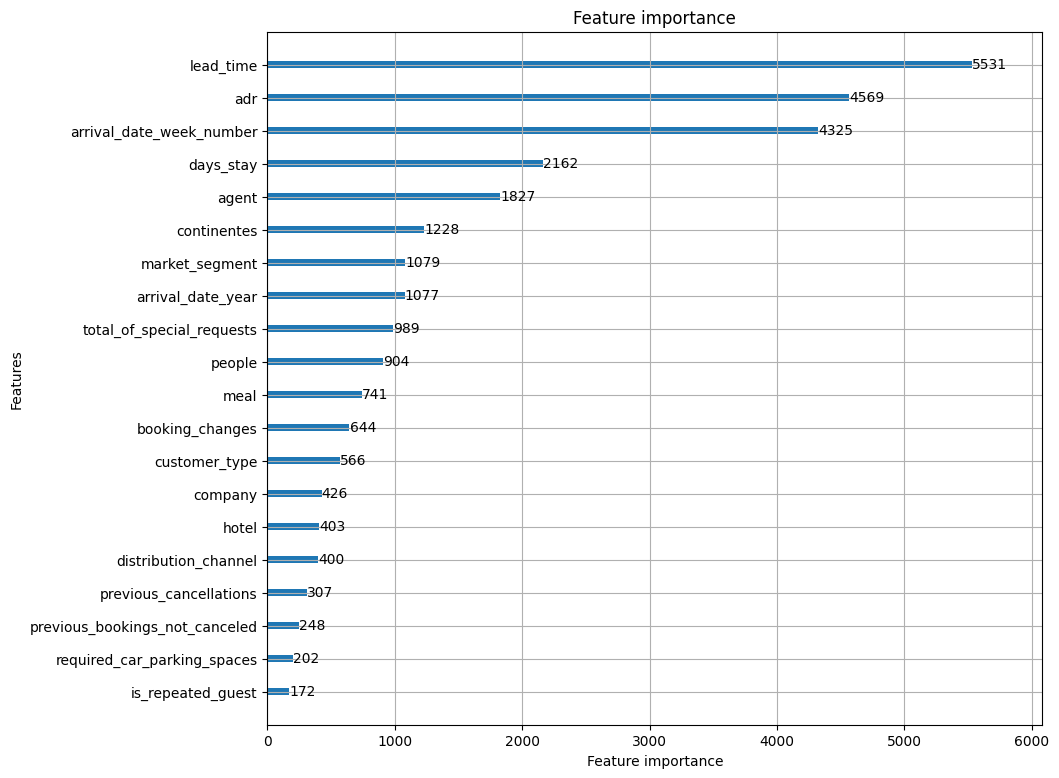

In [58]:
lgbm = LGBMClassifier(**lgbm_best_params)#**lgbm_best_params
lgbm.fit(X, y)
lightgbm.plot_importance(lgbm, figsize=(10, 9));

In [59]:
# fi_lgbm = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': lgbm.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10,6))
# plt.title('Feature Importance - LGBM Classifier')
# sns.barplot(data=fi_lgbm.head(20), x='importance', y='feature', color='SteelBlue');

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGBoost Feature Importance</p></div>

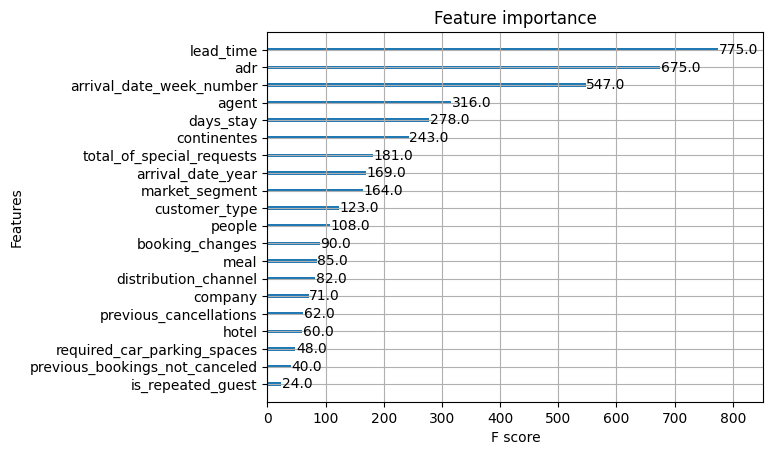

In [60]:
xgb = XGBClassifier()#**xgb_best_params
xgb.fit(X,y)
xgboost.plot_importance(xgb);

#fig1=plt.gcf()
#plt.draw()

In [62]:
# fi_xgb = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': xgb.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10,6))
# plt.title('Feature Importance - XGBoost Classifier')
# sns.barplot(data=fi_xgb.head(15), x='importance', y='feature', color='SteelBlue');
# plt.show()

## <div style="color:white;display:fill;border-radius:5px;background-color:#153656;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Filter Methods</p></div>

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Anova</p></div>

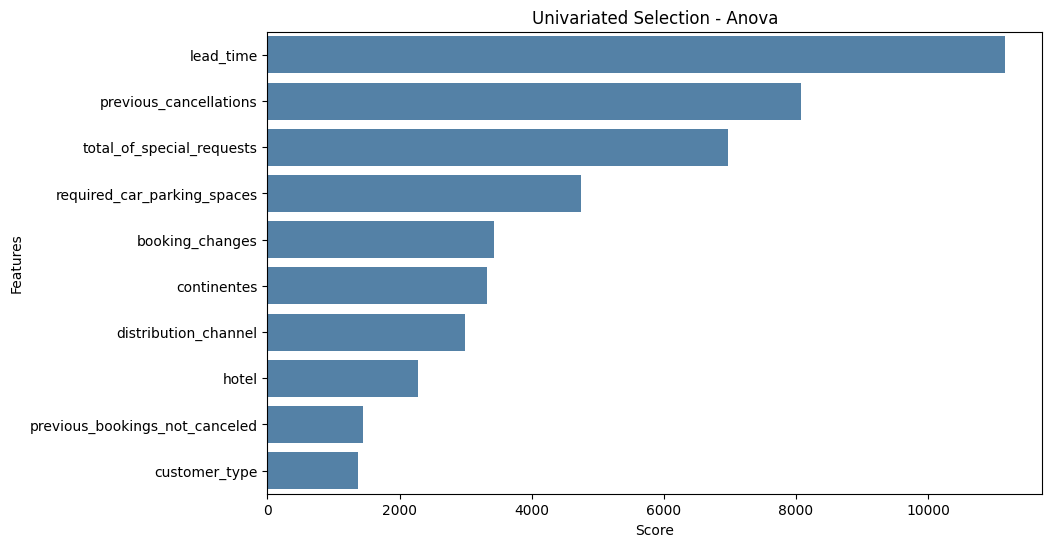

In [63]:
### Apply SelectKBest Algorithm - Anova
anova = SelectKBest(score_func=f_classif, k=10).fit(X,y)
anova_scores=pd.DataFrame(anova.scores_,columns=["Score"])
anova_columns=pd.DataFrame(X.columns)
anova_feature_rank=pd.concat([anova_columns,anova_scores],axis=1)
anova_feature_rank.columns=['Features','Score']
anova_feature_rank=anova_feature_rank.nlargest(10,'Score')

plt.figure(figsize=(10,6))
plt.title('Univariated Selection - Anova')
sns.barplot(data=anova_feature_rank, x='Score', y='Features', color='SteelBlue');
plt.show()

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Correlation Coeficient</p></div>

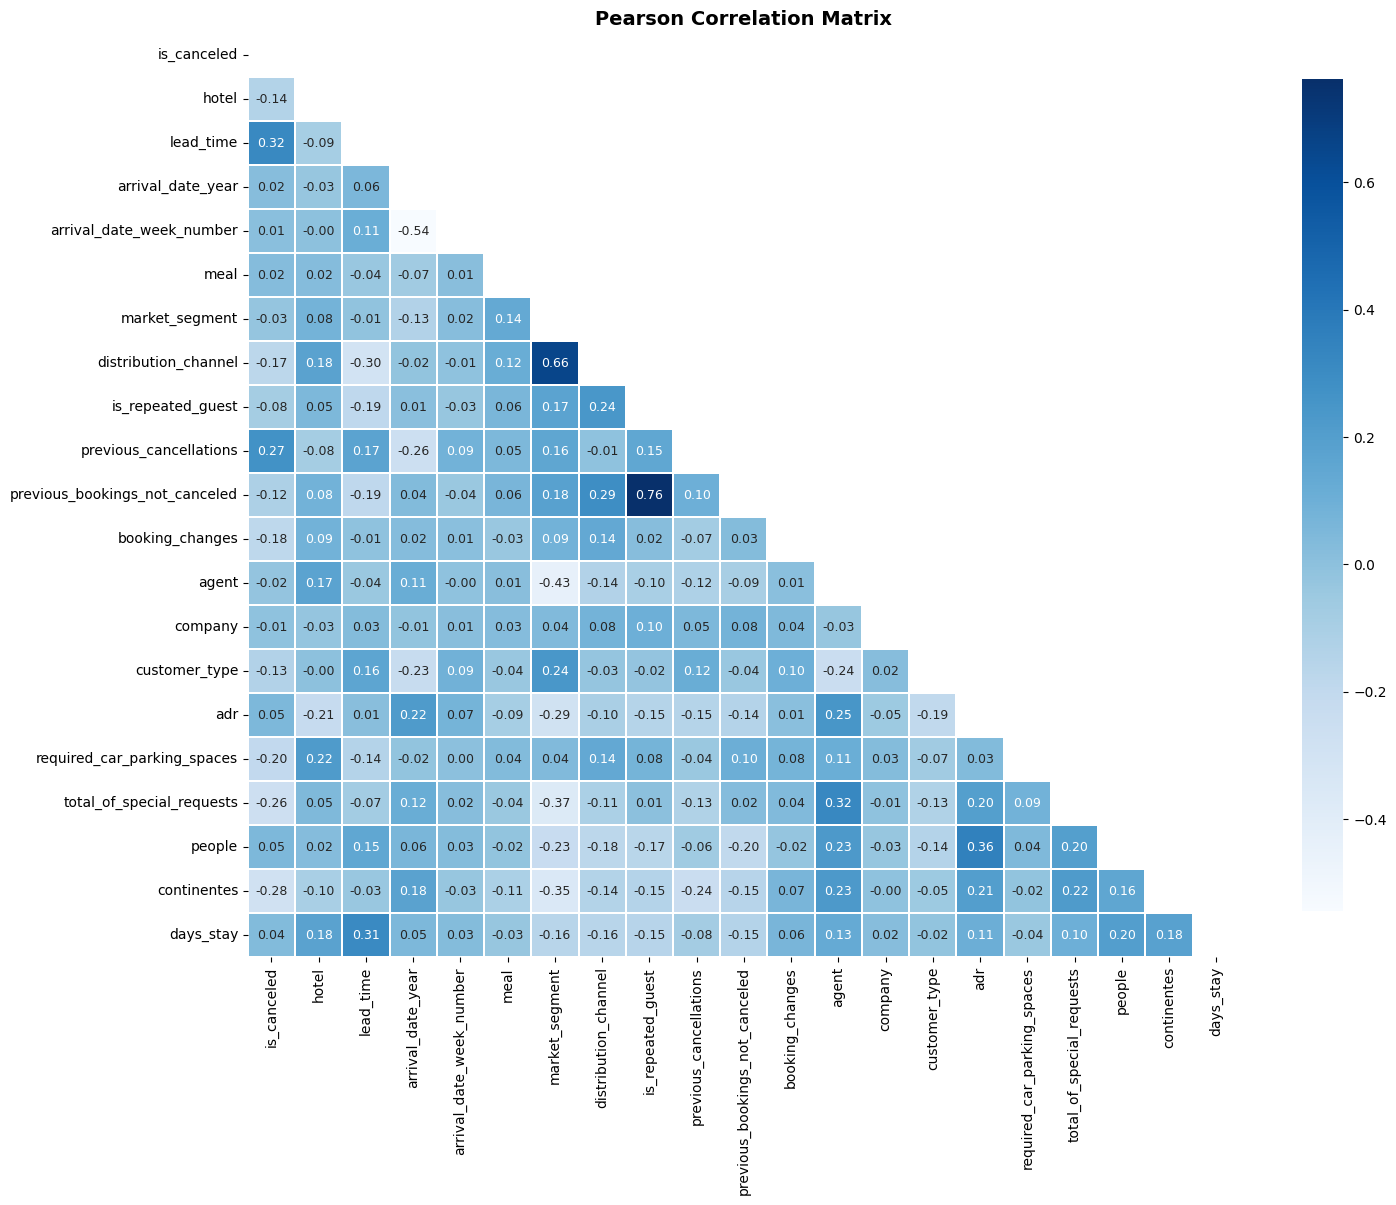

In [64]:
aux = pd.concat([data_prep[target],data_prep[selected_features]], axis=1)

mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Pearson Correlation Matrix',fontsize=14, fontweight='bold')

sns.heatmap(aux.corr(method='spearman'), linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

### <div style="color:white;display:fill;border-radius:5px;background-color:#4F4F4F;letter-spacing:0.5px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Shapley</p></div>

In [65]:
shap.initjs()

In [66]:
model = LGBMClassifier(**lgbm_best_params)#**lgbm_best_params
model.fit(X, y)


explainer = shap.Explainer(model, X)
shap_values = explainer(X)

100%|===================| 119203/119234 [13:10<00:00]        

In [453]:
# train = pd.concat([X,y], axis=1)
# train.loc[train.is_canceled ==1].tail()

In [68]:
#300 Not Canceled, Resort Hotel, Parking Required - Acertou
#96 Canceled, Native, Special Request - Acertou

#138,630 Canceled,
#630 Canceled
#120 Not Canceled, Resort Hotel, Native
#151 Not Canceled, Resort Hotel, No Native

#96655 Not Canceled, City Hotel, No Native
#95241 Not Canceled City Hotel, No Native
idx = 96655

In [69]:
data.iloc[idx,:]

hotel                                City Hotel
is_canceled                                   0
lead_time                                    94
arrival_date_year                          2016
arrival_date_month                            9
arrival_date_week_number                     36
arrival_date_day_of_month                     3
stays_in_weekend_nights                       2
stays_in_week_nights                          2
adults                                        2
children                                      1
babies                                        0
meal                                         BB
country                                     ITA
market_segment                    Offline TA/TO
distribution_channel                      TA/TO
is_repeated_guest                             0
previous_cancellations                        0
previous_bookings_not_canceled                0
reserved_room_type                            A
assigned_room_type                      

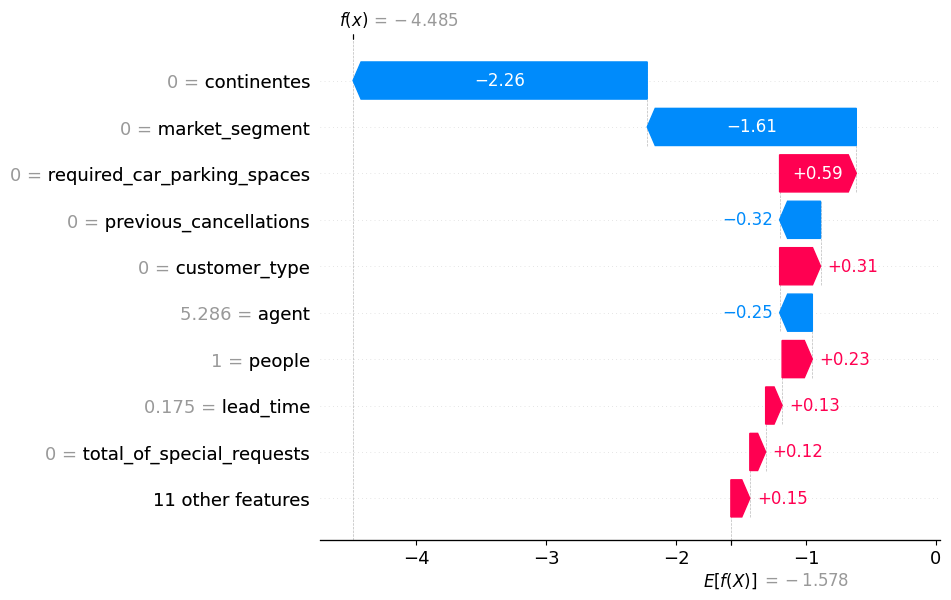

In [70]:
shap.plots.waterfall(shap_values[idx,:])

In [71]:
# visualize the first prediction's explanation with a force plot
#shap.plots.force(shap_values[idx,:])

/home/alysson/.local/lib/python3.10/site-packages/shap/plots/_beeswarm.py:340: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



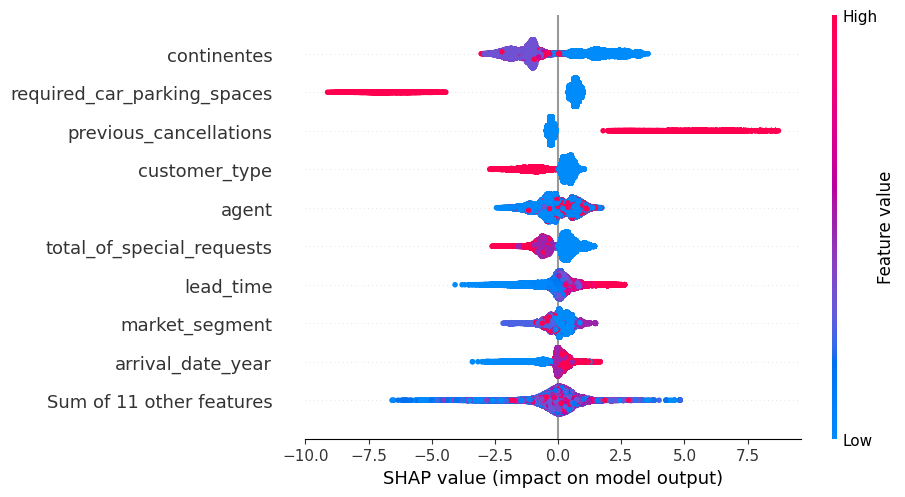

In [72]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

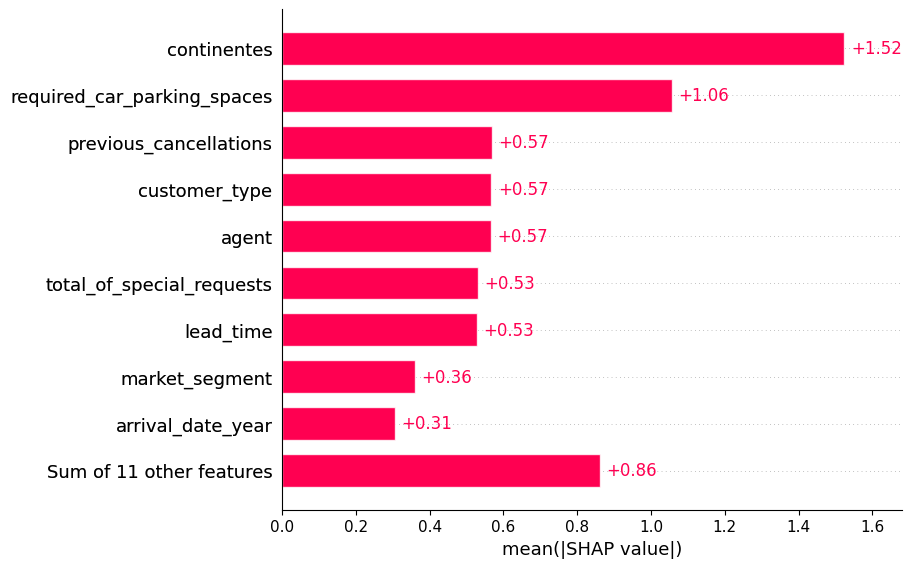

In [73]:
shap.plots.bar(shap_values)

In [75]:
shap.plots.force(shap_values[0:20])

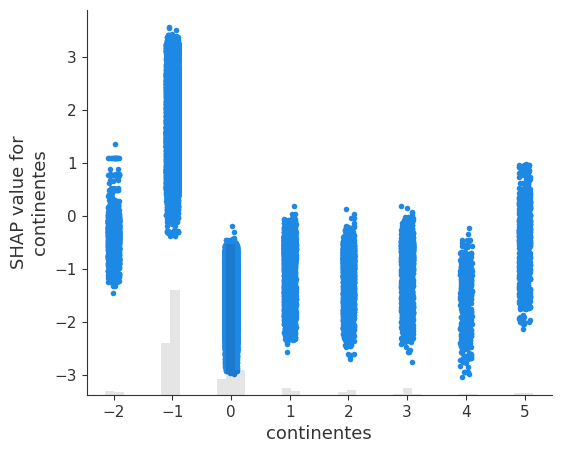

In [76]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"continentes"])#, color=shap_values

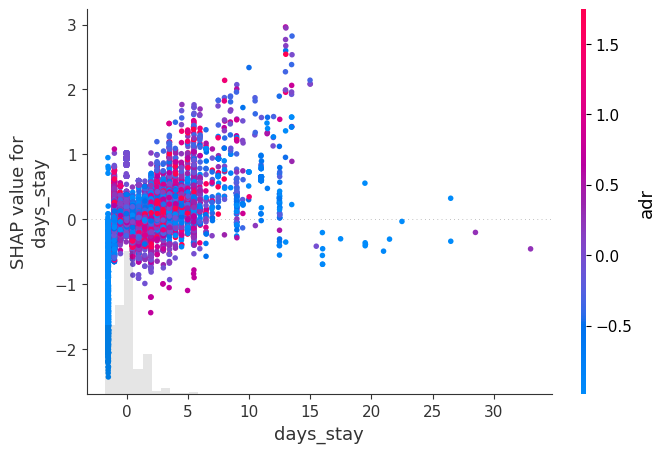

In [77]:
shap.plots.scatter(shap_values[:,"days_stay"],
                   color=shap_values[:,"adr"])